In [1]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geopy.distance
from shapely.ops import nearest_points

### Load Polling Place Data (2020)

In [2]:
polling = geopandas.read_file('Data/2020 Polling Data/polling_pk_master_post.csv')
early = geopandas.read_file('Data/2020 Polling Data/earlyVote_pk_master.csv')
dropoff = geopandas.read_file('Data/2020 Polling Data/dropoff_pk_master.csv')

In [3]:
polling = polling.replace(r'^\s*$', np.nan, regex=True)

In [4]:
polling = polling.astype({'latitude': 'float'})
polling = polling.astype({'longitude': 'float'})

In [5]:
polling_gdf = geopandas.GeoDataFrame(
    polling, geometry=geopandas.points_from_xy(polling.longitude, polling.latitude))

In [6]:
polling_gdf.head()

,query_id,placekey,error,pollingHours,latitude,longitude,sources,address.locationName,address.line1,address.city,address.state,address.zip,notes,startDate,endDate,address.line2,address.line3,id,geometry
0,0,223@8m4-tbj-bp9,NaN,"Tue, Nov 3: 7 am - 7 pm",21.305224,-157.857002,"[{'name': 'Voting Information Project', 'offic...",Honolulu Hale,530 South King Street,Honolulu,HI,96813,Voter service centers provide accessible in-pe...,11/3/2020,11/3/2020,NaN,NaN,NaN,POINT (-157.85700 21.30522)
1,1,@8m4-t4v-q4v,Invalid address,"Tue, Nov 3: 7 am - 7 pm",21.329854,-158.081865,"[{'name': 'Voting Information Project', 'offic...",Kapolei Hale,1000 Uluʻōhiʻa Street,Kapolei,HI,96707,Voter service centers provide accessible in-pe...,11/3/2020,11/3/2020,NaN,NaN,NaN,POINT (-158.08186 21.32985)
2,2,@8m4-793-jvz,Invalid address,"Tue, Nov 3: 7 am - 7 pm",21.090406,-157.017609,"[{'name': 'Voting Information Project', 'offic...",Mitchell Pauole Center Conference Room,90 Ainoa Street,Kaunakakai,HI,96748,Voter service centers provide accessible in-pe...,11/3/2020,11/3/2020,NaN,NaN,NaN,POINT (-157.01761 21.09041)
3,3,@bp5-ytd-j35,Invalid address,"Tue, Nov 3: 7 am - 7 pm",20.826513,-156.921143,"[{'name': 'Voting Information Project', 'offic...",Lanai Council District Office Lanai Community ...,Lanai Council District Office,Lanai City,HI,96763,Voter service centers provide accessible in-pe...,11/3/2020,11/3/2020,8th Street,NaN,NaN,POINT (-156.92114 20.82651)
4,4,zzw-222@bp5-chr-8y9,NaN,"Tue, Nov 3: 7 am - 7 pm",20.900159,-156.491939,"[{'name': 'Voting Information Project', 'offic...",Velma McWayne Santos Community Center,395 Waena Street,Wailuku,HI,96793,Voter service centers provide accessible in-pe...,11/3/2020,11/3/2020,NaN,NaN,NaN,POINT (-156.49194 20.90016)


### Load Final List of Colleges 

In [18]:
college = geopandas.read_file('Data/final_college_polygons.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
print(len(college))

5801


In [19]:
college['centroid'] = college.centroid
college.head()

,field_1,amenity,name,x_centroid,y_centroid,centroid_geom,State,geometry,centroid
0,0,university,university of maine at farmington,-70.14855977361351,44.667716528225185,"-70.14855977361351, 44.667716528225185",Maine,"POLYGON ((-70.14970 44.66690, -70.14992 44.666...",POINT (-70.14856 44.66772)
1,5,university,university of new england,-70.29558115483873,43.68372851427986,"-70.29558115483873, 43.68372851427986",Maine,"POLYGON ((-70.29412 43.68166, -70.29394 43.683...",POINT (-70.29558 43.68373)
2,21,university,husson university,-68.79287296592334,44.82687956818894,"-68.79287296592334, 44.82687956818894",Maine,"POLYGON ((-68.79622 44.82753, -68.79638 44.827...",POINT (-68.79287 44.82688)
3,22,university,university of maine orono,-68.66763403907045,44.9001740271891,"-68.66763403907045, 44.9001740271891",Maine,"POLYGON ((-68.65823 44.90509, -68.65892 44.905...",POINT (-68.66763 44.90017)
4,24,university,university of maine at fort kent,-68.58996654668397,47.24993548254448,"-68.58996654668397, 47.24993548254448",Maine,"POLYGON ((-68.59095 47.25073, -68.59134 47.250...",POINT (-68.58997 47.24994)


### Find Nearest Polling Place

In [20]:
unary_union = polling_gdf['geometry'].unary_union

In [21]:
def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    value = list(df2[nearest][src_column])[0]
    return value

In [22]:
%%time
college['nearest_id'] = college.apply(nearest, geom_union=unary_union, df1=college, df2=polling_gdf, geom1_col='centroid', src_column='address.locationName', axis=1)
college['nearest_id_geometry'] = college.apply(nearest, geom_union=unary_union, df1=college, df2=polling_gdf, geom1_col='centroid', src_column='geometry', axis=1)

CPU times: user 3h 30min 19s, sys: 10.1 s, total: 3h 30min 29s
Wall time: 3h 30min 42s


In [25]:
college.head()

,field_1,amenity,name,x_centroid,y_centroid,centroid_geom,State,geometry,centroid,nearest_id,nearest_id_geometry
0,0,university,university of maine at farmington,-70.14855977361351,44.667716528225185,"-70.14855977361351, 44.667716528225185",Maine,"POLYGON ((-70.14970 44.66690, -70.14992 44.666...",POINT (-70.14856 44.66772),Community Center,POINT (-70.1459954 44.659998)
1,5,university,university of new england,-70.29558115483873,43.68372851427986,"-70.29558115483873, 43.68372851427986",Maine,"POLYGON ((-70.29412 43.68166, -70.29394 43.683...",POINT (-70.29558 43.68373),Deering High School Gymnasium,POINT (-70.29579029999999 43.6720199)
2,21,university,husson university,-68.79287296592334,44.82687956818894,"-68.79287296592334, 44.82687956818894",Maine,"POLYGON ((-68.79622 44.82753, -68.79638 44.827...",POINT (-68.79287 44.82688),Cross Insurance Center Concourse,POINT (-68.7792895 44.7888019)
3,22,university,university of maine orono,-68.66763403907045,44.9001740271891,"-68.66763403907045, 44.9001740271891",Maine,"POLYGON ((-68.65823 44.90509, -68.65892 44.905...",POINT (-68.66763 44.90017),New Balance Field House & Memorial Gym,POINT (-68.66997979999999 44.9037526)
4,24,university,university of maine at fort kent,-68.58996654668397,47.24993548254448,"-68.58996654668397, 47.24993548254448",Maine,"POLYGON ((-68.59095 47.25073, -68.59134 47.250...",POINT (-68.58997 47.24994),Knights of Columbus Hall,POINT (-68.58447750000001 47.2767531)


### Find Distance Between Centroid + Nearest Polling Place

In [46]:
college = college.astype({'nearest_id_geometry': 'geometry'})
college['c_lon'] = college.centroid.x
college['c_lat'] = college.centroid.y
college['n_lon'] = college.nearest_id_geometry.x
college['n_lat'] = college.nearest_id_geometry.y

In [47]:
def get_dist(row): 
    return geopy.distance.geodesic((row['c_lat'],row['c_lon']),(row['n_lat'],row['n_lon'])).miles

In [48]:
#Calculate Mileage Distance
college['mile_dist'] = pd.DataFrame(college.apply(lambda row: get_dist(row), axis=1).tolist(), index= college.index)
college.head()

,field_1,amenity,name,x_centroid,y_centroid,centroid_geom,State,geometry,centroid,nearest_id,nearest_id_geometry,n_lon,n_lat,c_lon,c_lat,mile_dist
0,0,university,university of maine at farmington,-70.14855977361351,44.667716528225185,"-70.14855977361351, 44.667716528225185",Maine,"POLYGON ((-70.14970 44.66690, -70.14992 44.666...",POINT (-70.14856 44.66772),Community Center,POINT (-70.14600 44.66000),-70.145995,44.659998,-70.148560,44.667717,0.547741
1,5,university,university of new england,-70.29558115483873,43.68372851427986,"-70.29558115483873, 43.68372851427986",Maine,"POLYGON ((-70.29412 43.68166, -70.29394 43.683...",POINT (-70.29558 43.68373),Deering High School Gymnasium,POINT (-70.29579 43.67202),-70.295790,43.672020,-70.295581,43.683729,0.808408
2,21,university,husson university,-68.79287296592334,44.82687956818894,"-68.79287296592334, 44.82687956818894",Maine,"POLYGON ((-68.79622 44.82753, -68.79638 44.827...",POINT (-68.79287 44.82688),Cross Insurance Center Concourse,POINT (-68.77929 44.78880),-68.779290,44.788802,-68.792873,44.826880,2.712788
3,22,university,university of maine orono,-68.66763403907045,44.9001740271891,"-68.66763403907045, 44.9001740271891",Maine,"POLYGON ((-68.65823 44.90509, -68.65892 44.905...",POINT (-68.66763 44.90017),New Balance Field House & Memorial Gym,POINT (-68.66998 44.90375),-68.669980,44.903753,-68.667634,44.900174,0.272611
4,24,university,university of maine at fort kent,-68.58996654668397,47.24993548254448,"-68.58996654668397, 47.24993548254448",Maine,"POLYGON ((-68.59095 47.25073, -68.59134 47.250...",POINT (-68.58997 47.24994),Knights of Columbus Hall,POINT (-68.58448 47.27675),-68.584478,47.276753,-68.589967,47.249935,1.870499


In [49]:
college['mile_dist'].mean()

1.7778113305182148

(array([5.764e+03, 1.900e+01, 3.000e+00, 1.100e+01, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([2.09609284e-03, 3.39828630e+01, 6.79636298e+01, 1.01944397e+02,
        1.35925164e+02, 1.69905930e+02, 2.03886697e+02, 2.37867464e+02,
        2.71848231e+02, 3.05828998e+02, 3.39809765e+02]),
 <a list of 10 Patch objects>)

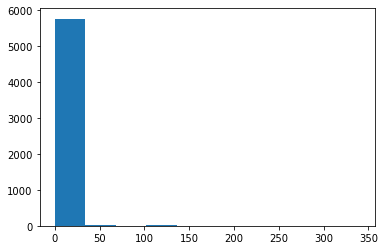

In [50]:
plt.hist(college['mile_dist'])

In [51]:
college.describe()

,n_lon,n_lat,c_lon,c_lat,mile_dist
count,5801.000000,5801.000000,5801.000000,5801.000000,5801.000000
mean,-90.155633,37.989593,-90.152711,37.987065,1.777811
std,15.182437,5.010035,15.172189,5.011335,9.818204
min,-166.537517,25.632859,-165.396562,25.620916,0.002096
25%,-96.934610,34.017661,-96.932282,34.016987,0.336783
50%,-85.740568,38.827144,-85.705229,38.820457,0.665926
75%,-78.808398,41.490148,-78.805974,41.490663,1.158109
max,-68.019394,66.895161,-68.018545,71.324811,339.809765
